#1. BiLSTM에 익숙해지기

In [ ]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [ ]:
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [ ]:
sentences, pos_tags = [], [] 
for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장한다.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.

In [ ]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


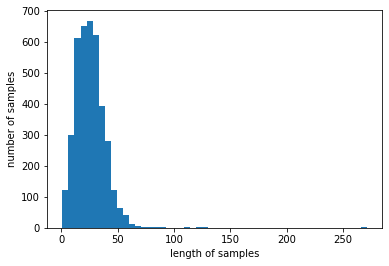

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [ ]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [ ]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (2504, 150)
훈련 샘플 레이블의 크기 : (2504, 150, 47)
테스트 샘플 문장의 크기 : (627, 150)
테스트 샘플 레이블의 크기 : (627, 150, 47)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=6,  validation_data=(X_test, y_test))

Epoch 1/6
20/20 [==============================] - 73s 3s/step - loss: 0.6302 - accuracy: 0.1161 - val_loss: 0.5119 - val_accuracy: 0.1456
Epoch 2/6
20/20 [==============================] - 62s 3s/step - loss: 0.5259 - accuracy: 0.1568 - val_loss: 0.4807 - val_accuracy: 0.2208
Epoch 3/6
20/20 [==============================] - 61s 3s/step - loss: 0.4815 - accuracy: 0.2726 - val_loss: 0.4252 - val_accuracy: 0.4102
Epoch 4/6
20/20 [==============================] - 63s 3s/step - loss: 0.4055 - accuracy: 0.4468 - val_loss: 0.3037 - val_accuracy: 0.5490
Epoch 5/6
20/20 [==============================] - 61s 3s/step - loss: 0.2757 - accuracy: 0.5947 - val_loss: 0.1957 - val_accuracy: 0.7174
Epoch 6/6
20/20 [==============================] - 62s 3s/step - loss: 0.1681 - accuracy: 0.7812 - val_loss: 0.1219 - val_accuracy: 0.8318


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))


20/20 [==============================] - 6s 276ms/step - loss: 0.1219 - accuracy: 0.8318

 테스트 정확도: 0.8318


In [ ]:
index_to_word=src_tokenizer.index_word
index_to_tag=tar_tokenizer.index_word

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
mr.              : NNP     NNP
simmons          : NNP     NNP
and              : CC      CC
nl               : NNP     NNP
already          : RB      RB
own              : VB      JJ
a                : DT      DT
9.9              : CD      JJ
%                : NN      NN
stake            : NN      NN
in               : IN      IN
georgia          : NNP     NNP
gulf             : NNP     NNP
.                : .       .


#2. BiLSTM을 이용한 개체명 인식(한국어) : 이 부분이 핵심!!

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 8.1MB/s 
     |████████████████████████████████| 460kB 69.6MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import numpy as np
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
okt = Okt()

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/elymas/ai_chatbot_class/master/07_chatbot_class/tuto07(Intent%2C%20Entity)/Entity/train_entity.csv", filename="train_entity.csv")

('train_entity.csv', <http.client.HTTPMessage at 0x7f2e73ce6650>)

In [ ]:
data = pd.read_csv("train_entity.csv", encoding="euc-kr")

In [ ]:
data.sample(50)

,다음 DATE
7252,모레 DATE
8191,말해줄래 O
7224,구리 LOCATION
1731,날씨 O
652,속초 LOCATION
13013,하니 O
6264,알려줘요 O
2237,내일 DATE
14288,좋니 O
9300,날씨 O


In [ ]:
with open('train_entity.csv', encoding='euc-kr') as f:
    tokenized_sentences, labels = [], []
    tokenized_sentence, label = [], []
    for line in f:
        line = line.strip()
        if (len(line) == 0 or line.startswith("-DOCSTART-")):
            if not len(tokenized_sentence) == 0:
                tokenized_sentences.append(tokenized_sentence)
                labels.append(label)
                tokenized_sentence, label = [], [] #초기화
        else:
            word, tag = line.split(' ')
            tokenized_sentence.append(word)
            label.append(tag)

In [ ]:
tokenized_sentences[:5]

[['다음', '주', '전주', '비', '오려나'],
 ['이번', '주', '서울', '눈', '오니'],
 ['이번', '주', '대구', '날씨', '비', '오는지', '알려줘'],
 ['부산', '이번', '주', '날씨', '맑은지', '알려줄래'],
 ['광주', '이번', '주', '눈', '오려나']]

In [ ]:
labels[:5]

[['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O']]

데이터가 이미 토큰화되어 제공되고 있으나, 태소 분석기에 따라서 토큰화 결과가 다르므로 사용하고자 하는 형태소 분석기에 맞게 재토큰화를 해보겠습니다.

In [ ]:
for ts, label in zip(tokenized_sentences, labels):
    for idx, word in enumerate(ts):
        if len(okt.morphs(word))>1:
            tokenized_word = okt.morphs(word)
            ts.pop(idx)
            tag = label.pop(idx)
            for i in tokenized_word[::-1]:
                ts.insert(idx, i)
                label.insert(idx, tag)

In [ ]:
tokenized_sentences[:5]

[['다음', '주', '전주', '비', '오려나'],
 ['이번', '주', '서울', '눈', '오니'],
 ['이번', '주', '대구', '날씨', '비', '오는지', '알려줘'],
 ['부산', '이번', '주', '날씨', '맑은', '지', '알려줄래'],
 ['광주', '이번', '주', '눈', '오려나']]

In [ ]:
labels[:5]

[['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O'],
 ['DATE', 'DATE', 'LOCATION', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O', 'O', 'O'],
 ['LOCATION', 'DATE', 'DATE', 'O', 'O']]

In [ ]:
print('샘플 수 :',len(tokenized_sentences))
print('레이블 수 :',len(labels))

샘플 수 : 3851
레이블 수 : 3851


샘플의 최대 길이 : 24
샘플의 평균 길이 : 4.541418


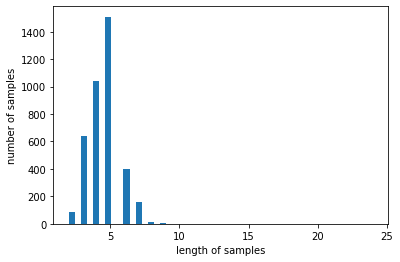

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in tokenized_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, tokenized_sentences))/len(tokenized_sentences)))
plt.hist([len(s) for s in tokenized_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(tokenized_sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(labels)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 533
개체명 태깅 정보 집합의 크기 : 4


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [ ]:
X_data = src_tokenizer.texts_to_sequences(tokenized_sentences)
y_data = tar_tokenizer.texts_to_sequences(labels)

In [ ]:
print(X_data[0])
print(y_data[0])

[47, 8, 25, 15, 53]
[3, 3, 2, 1, 1]


In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'LOCATION', 3: 'DATE', 0: 'PAD'}


In [ ]:
decoded = []
for index in X_data[0] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존의 문장 : {}'.format(tokenized_sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['다음', '주', '전주', '비', '오려나']
디코딩 문장 : ['다음', '주', '전주', '비', '오려나']


In [ ]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
y_data  = to_categorical(y_data , num_classes=tag_size)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 64)            34112     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 128)           66048     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 4)             516       
Total params: 100,676
Trainable params: 100,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_data, y_data, batch_size=32, epochs=3)

Epoch 1/3
121/121 [==============================] - 10s 10ms/step - loss: 0.0626 - accuracy: 0.6647
Epoch 2/3
121/121 [==============================] - 1s 8ms/step - loss: 0.0054 - accuracy: 0.9802
Epoch 3/3
121/121 [==============================] - 1s 7ms/step - loss: 8.8660e-04 - accuracy: 0.9979


In [ ]:
prediction = '내일 부산 날씨는?'

In [ ]:
tokens = okt.morphs(prediction)
print(tokens)

['내일', '부산', '날씨', '는', '?']


In [ ]:
encoded = []

for word in tokens:
  if word in word_to_index:
    encoded.append(word_to_index[word])
  else:
    encoded.append(word_to_index['OOV'])

In [ ]:
print(encoded)

[5, 29, 2, 1, 1]


In [ ]:
y_predicted = model.predict([encoded], verbose=False)[0]

In [ ]:
print(y_predicted)

[[1.42879835e-05 2.68185395e-04 4.54490160e-04 9.99263108e-01]
 [7.79799393e-06 2.88926880e-03 9.96588230e-01 5.14661486e-04]
 [1.11156578e-06 9.99835610e-01 1.62063356e-04 1.20447203e-06]
 [2.90016236e-04 9.90020275e-01 9.62359738e-03 6.62172752e-05]
 [3.11723852e-04 9.91826177e-01 7.80753139e-03 5.46172487e-05]]


In [ ]:
y_predicted = y_predicted.argmax(axis=-1)
print(y_predicted)

[3 2 1 1 1]


In [ ]:
y_predicted = [index_to_ner[x].strip() for x in y_predicted]

In [ ]:
print(y_predicted)

['DATE', 'LOCATION', 'O', 'O', 'O']


In [ ]:
list(zip(tokens, y_predicted))

[('내일', 'DATE'), ('부산', 'LOCATION'), ('날씨', 'O'), ('는', 'O'), ('?', 'O')]